## Importing Libraries and Data Visualization
In this section, we import the necessary libraries such as `torch`, `torchvision`, and `matplotlib`. We also define a basic transformation pipeline and visualize a sample image from the training dataset to understand the data we are working with.

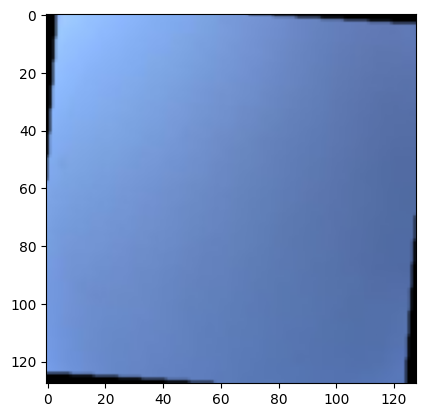

In [26]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Precision, Recall
import torch

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Resize((128, 128))
])

dataset_train = ImageFolder(
    "clouds/clouds_train",
    transform=train_transform
)

dataloader_train = DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=1
)

image, label = next(iter(dataloader_train))

image = image.squeeze().permute(1, 2, 0)
plt.imshow(image)
plt.show()

## Defining the Convolutional Neural Network (CNN)
Here, we define a simple CNN architecture using `nn.Module`. The network consists of two convolutional layers followed by max-pooling and ELU activation functions. The output is flattened and passed through a fully connected (linear) layer for classification.

In [27]:
#Building convolutional networks

class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 1st conv layer
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 2nd conv layer
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        # Define classifier
        self.classifier = nn.Linear(64*16*16, num_classes)
    
    def forward(self, x):  
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

## Data Augmentation and DataLoaders
We define data augmentation techniques for the training set, such as random horizontal flips and rotations, to improve model generalization. We then create `DataLoader` objects for both training and testing datasets, which handle batching and shuffling.

In [28]:
# Dataset with augmentations
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

dataset_train = ImageFolder(
  "clouds/clouds_train",
  transform=train_transforms,
)
dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=16
)

# Create test dataset and dataloader
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

dataset_test = ImageFolder(
  "clouds/clouds_test",
  transform=test_transforms,
)
dataloader_test = DataLoader(
  dataset_test, shuffle=False, batch_size=16
)


## Training the Model
This cell contains the training loop. We instantiate the model, define the CrossEntropyLoss function, and use the Adam optimizer. The model is trained for 3 epochs, and the loss is printed after each epoch to monitor progress.

In [29]:
###### Image classifier training loop ######

# Define the model
net = Net(num_classes=7)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 1.8432
Epoch 2, Loss: 1.5783
Epoch 3, Loss: 1.4244


## Model Evaluation
After training, we evaluate the model's performance on the test set using Precision and Recall metrics. We calculate the macro average for these metrics to get an overall sense of how well the model performs across all classes.

In [30]:
###### Multi-class model evaluation ######


# Define metrics
metric_precision = Precision(task="multiclass", num_classes=7, average="macro")
metric_recall = Recall(task="multiclass", num_classes=7, average="macro")

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.7190513610839844
Recall: 0.45328211784362793


## Per-Class Precision
To get more granular insights, we calculate the precision for each individual class. This helps us identify which classes the model predicts well and which ones it struggles with.

In [32]:
metric_precision = Precision(
    task="multiclass",
    num_classes=7,
    average=None
)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
    per_class_precision = metric_precision.compute()

precision_per_class = {
    k: per_class_precision[v].item()
    for k, v in dataset_test.class_to_idx.items()
}

print(precision_per_class)

{'cirriform clouds': 1.0, 'clear sky': 0.5526315569877625, 'cumulonimbus clouds': 1.0, 'cumulus clouds': 0.43127962946891785, 'high cumuliform clouds': 0.6399999856948853, 'stratiform clouds': 1.0, 'stratocumulus clouds': 0.4094488322734833}
